# Lista 04 - Tópicos III

In [1]:
import numpy as np
import os

In [2]:
train_dir = 'aclImdb/aclImdb/train/'
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
maxlen = 300 # Cuts off reviews after 300 words
training_samples = 2000 # Trains on 2000 samples
validation_samples = 600 # Validates on 600 samples (30%)
max_words = 10000 # Considers only the top 10,000 words in the dataset

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [8]:
data = pad_sequences(sequences, maxlen=maxlen)

In [9]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 300)
Shape of label tensor: (25000,)


## Splits the data into a training set and a validation set

In [10]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [11]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

## Parse index that maps words (as strings) to their vector representation (as number vectors)

In [13]:
glove_dir = 'glove.6B.100d.txt'
embeddings_index = {}
f = open(glove_dir, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector #Words not found in the embedding index will be all zeros.

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,960,065
Trainable params: 1,960,065
Non-trainable params: 0
_________________________________________________________________


## Freezing the embedded layer and using GloVe weights

In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [19]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=100,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 2000 samples, validate on 600 samples
Epoch 1/100
2000/2000 [==============================] - 1s 601us/step - loss: 0.0932 - acc: 0.9785 - val_loss: 0.8607 - val_acc: 0.6417
Epoch 2/100
2000/2000 [==============================] - 1s 463us/step - loss: 0.0416 - acc: 0.9870 - val_loss: 0.9064 - val_acc: 0.6617
Epoch 3/100
2000/2000 [==============================] - 1s 469us/step - loss: 0.0245 - acc: 0.9915 - val_loss: 1.0038 - val_acc: 0.6450
Epoch 4/100
2000/2000 [==============================] - 1s 465us/step - loss: 0.0223 - acc: 0.9915 - val_loss: 1.0686 - val_acc: 0.6317
Epoch 5/100
2000/2000 [==============================] - 1s 464us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.5666 - val_acc: 0.6050
Epoch 6/100
2000/2000 [==============================] - 1s 503us/step - loss: 0.0363 - acc: 0.9935 - val_loss: 1.1186 - val_acc: 0.6317
Epoch 7/100
2000/2000 [==============================] - 1s 477us/step - loss: 0.0200 - acc: 0.9940 - val_loss: 1.1323 - val_acc: 0

2000/2000 [==============================] - 1s 432us/step - loss: 1.0985e-07 - acc: 1.0000 - val_loss: 2.5000 - val_acc: 0.6533
Epoch 60/100
2000/2000 [==============================] - 1s 421us/step - loss: 1.0984e-07 - acc: 1.0000 - val_loss: 2.5012 - val_acc: 0.6533
Epoch 61/100
2000/2000 [==============================] - 1s 429us/step - loss: 1.0983e-07 - acc: 1.0000 - val_loss: 2.5026 - val_acc: 0.6533
Epoch 62/100
2000/2000 [==============================] - 1s 428us/step - loss: 1.0983e-07 - acc: 1.0000 - val_loss: 2.5036 - val_acc: 0.6533
Epoch 63/100
2000/2000 [==============================] - 1s 431us/step - loss: 1.0982e-07 - acc: 1.0000 - val_loss: 2.5044 - val_acc: 0.6533
Epoch 64/100
2000/2000 [==============================] - 1s 422us/step - loss: 1.0981e-07 - acc: 1.0000 - val_loss: 2.5063 - val_acc: 0.6533
Epoch 65/100
2000/2000 [==============================] - 1s 421us/step - loss: 1.0981e-07 - acc: 1.0000 - val_loss: 2.5044 - val_acc: 0.6533
Epoch 66/100
2000/2

## Report (item 1)

In [21]:
import matplotlib.pyplot as plt

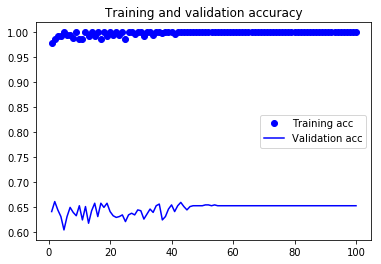

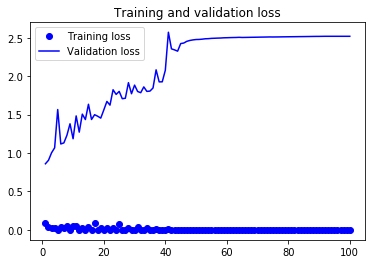

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

# No freeeze, no GloVe

In [24]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,960,065
Trainable params: 1,960,065
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=100,
batch_size=32,
validation_data=(x_val, y_val))

Train on 2000 samples, validate on 600 samples
Epoch 1/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6995 - acc: 0.4940 - val_loss: 0.6860 - val_acc: 0.5283
Epoch 2/100
2000/2000 [==============================] - 2s 834us/step - loss: 0.4876 - acc: 0.7560 - val_loss: 0.6054 - val_acc: 0.6533
Epoch 3/100
2000/2000 [==============================] - 2s 868us/step - loss: 0.1239 - acc: 0.9740 - val_loss: 0.5098 - val_acc: 0.7617
Epoch 4/100
2000/2000 [==============================] - 2s 848us/step - loss: 0.0155 - acc: 0.9995 - val_loss: 0.6458 - val_acc: 0.7017
Epoch 5/100
2000/2000 [==============================] - 2s 844us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.6828 - val_acc: 0.7350
Epoch 6/100
2000/2000 [==============================] - 2s 843us/step - loss: 2.1393e-04 - acc: 1.0000 - val_loss: 0.7488 - val_acc: 0.7283
Epoch 7/100
2000/2000 [==============================] - 2s 873us/step - loss: 8.4390e-06 - acc: 1.0000 - val_loss: 0.7939 - val_

2000/2000 [==============================] - 2s 829us/step - loss: 1.0975e-07 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.7400
Epoch 59/100
2000/2000 [==============================] - 2s 834us/step - loss: 1.0975e-07 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.7400
Epoch 60/100
2000/2000 [==============================] - 2s 832us/step - loss: 1.0975e-07 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.7400
Epoch 61/100
2000/2000 [==============================] - 2s 836us/step - loss: 1.0975e-07 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.7400
Epoch 62/100
2000/2000 [==============================] - 2s 832us/step - loss: 1.0975e-07 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.7400
Epoch 63/100
2000/2000 [==============================] - 2s 833us/step - loss: 1.0975e-07 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.7400
Epoch 64/100
2000/2000 [==============================] - 2s 828us/step - loss: 1.0975e-07 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.7400
Epoch 65/100
2000/2

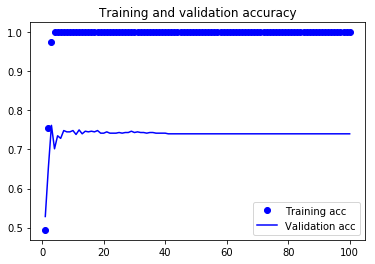

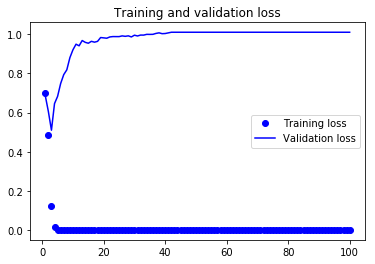

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

In [31]:
from keras.layers import Dropout, LSTM
dropout_p = [0.3, 0.4, 0.5]

In [35]:
def create_model(dropout_=False, p=0.0):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(LSTM(units=1))
    
    if dropout_:
        model.add(Dropout(p))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

## Report (item 2)

## Freeze and GloVe

In [38]:
arr_hist = []

for p in dropout_p:
    model = create_model(dropout_=True, p=p)
    
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    
    model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])
    history = model.fit(x_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_val, y_val))
    
    arr_hist.append(history)

Train on 2000 samples, validate on 600 samples
Epoch 1/25
2000/2000 [==============================] - 27s 13ms/step - loss: 0.6931 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4950
Epoch 2/25
2000/2000 [==============================] - 34s 17ms/step - loss: 0.6926 - acc: 0.5085 - val_loss: 0.6929 - val_acc: 0.5067
Epoch 3/25
2000/2000 [==============================] - 28s 14ms/step - loss: 0.6922 - acc: 0.5055 - val_loss: 0.6929 - val_acc: 0.4950
Epoch 4/25
2000/2000 [==============================] - 25s 13ms/step - loss: 0.6923 - acc: 0.5040 - val_loss: 0.6934 - val_acc: 0.4950
Epoch 5/25
2000/2000 [==============================] - 26s 13ms/step - loss: 0.6916 - acc: 0.4985 - val_loss: 0.6929 - val_acc: 0.4917
Epoch 6/25
2000/2000 [==============================] - 25s 12ms/step - loss: 0.6911 - acc: 0.5060 - val_loss: 0.6929 - val_acc: 0.5367
Epoch 7/25
2000/2000 [==============================] - 26s 13ms/step - loss: 0.6910 - acc: 0.5260 - val_loss: 0.6944 - val_acc: 0.5000
E

Epoch 10/25
2000/2000 [==============================] - 22s 11ms/step - loss: 0.6667 - acc: 0.5775 - val_loss: 0.6636 - val_acc: 0.6350
Epoch 11/25
2000/2000 [==============================] - 23s 11ms/step - loss: 0.6518 - acc: 0.5885 - val_loss: 0.6506 - val_acc: 0.6300
Epoch 12/25
2000/2000 [==============================] - 24s 12ms/step - loss: 0.6484 - acc: 0.5885 - val_loss: 0.6371 - val_acc: 0.6383
Epoch 13/25
2000/2000 [==============================] - 23s 12ms/step - loss: 0.6381 - acc: 0.6025 - val_loss: 0.6256 - val_acc: 0.6767
Epoch 14/25
2000/2000 [==============================] - 21s 11ms/step - loss: 0.6316 - acc: 0.5980 - val_loss: 0.6075 - val_acc: 0.6817
Epoch 15/25
2000/2000 [==============================] - 21s 11ms/step - loss: 0.6285 - acc: 0.6155 - val_loss: 0.5961 - val_acc: 0.7017
Epoch 16/25
2000/2000 [==============================] - 26s 13ms/step - loss: 0.6034 - acc: 0.6380 - val_loss: 0.5818 - val_acc: 0.7067
Epoch 17/25
2000/2000 [==================

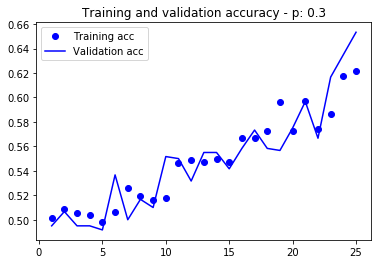

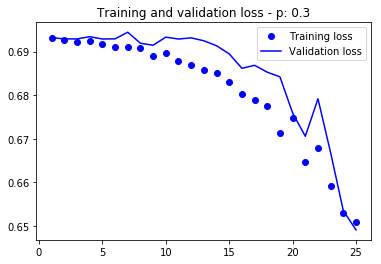

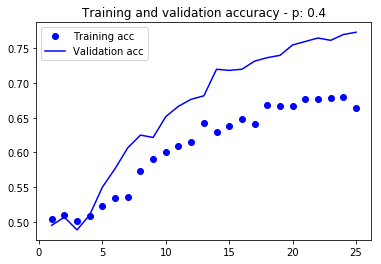

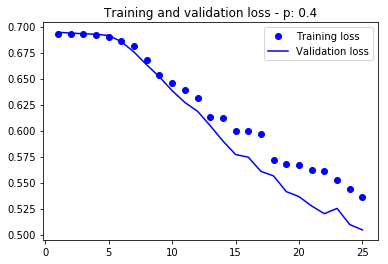

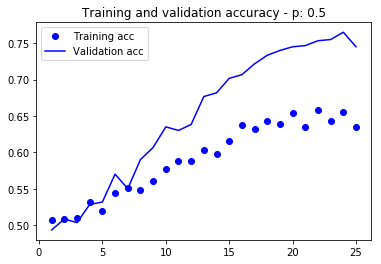

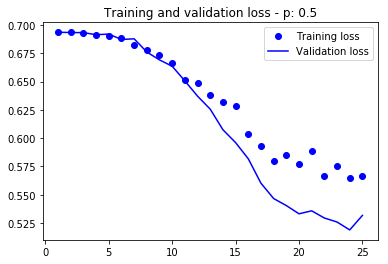

In [41]:
for history, p in zip(arr_hist, dropout_p):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy - p: {}'.format(p))
    plt.legend(loc='best')

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss - p: {}'.format(p))
    plt.legend(loc='best')
    
    plt.show()

## No freeze, no GloVe

In [42]:
arr_hist = []

for p in dropout_p:
    model = create_model(dropout_=True, p=p)
    
    model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])
    history = model.fit(x_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_val, y_val))
    
    arr_hist.append(history)

Train on 2000 samples, validate on 600 samples
Epoch 1/25
2000/2000 [==============================] - 30s 15ms/step - loss: 0.6910 - acc: 0.5480 - val_loss: 0.6866 - val_acc: 0.5750
Epoch 2/25
2000/2000 [==============================] - 27s 13ms/step - loss: 0.6724 - acc: 0.6365 - val_loss: 0.6692 - val_acc: 0.6367
Epoch 3/25
2000/2000 [==============================] - 31s 16ms/step - loss: 0.6345 - acc: 0.6820 - val_loss: 0.6405 - val_acc: 0.6767
Epoch 4/25
2000/2000 [==============================] - 26s 13ms/step - loss: 0.5816 - acc: 0.6975 - val_loss: 0.6081 - val_acc: 0.6933
Epoch 5/25
2000/2000 [==============================] - 28s 14ms/step - loss: 0.5218 - acc: 0.7365 - val_loss: 0.5915 - val_acc: 0.6983
Epoch 6/25
2000/2000 [==============================] - 27s 14ms/step - loss: 0.4695 - acc: 0.7500 - val_loss: 0.5826 - val_acc: 0.6983
Epoch 7/25
2000/2000 [==============================] - 24s 12ms/step - loss: 0.4281 - acc: 0.7510 - val_loss: 0.5851 - val_acc: 0.7083
E

Epoch 10/25
2000/2000 [==============================] - 27s 14ms/step - loss: 0.4072 - acc: 0.7235 - val_loss: 0.4606 - val_acc: 0.7933
Epoch 11/25
2000/2000 [==============================] - 25s 13ms/step - loss: 0.3858 - acc: 0.7525 - val_loss: 0.4847 - val_acc: 0.7750
Epoch 12/25
2000/2000 [==============================] - 23s 12ms/step - loss: 0.3883 - acc: 0.7490 - val_loss: 0.4906 - val_acc: 0.7717
Epoch 13/25
2000/2000 [==============================] - 28s 14ms/step - loss: 0.3818 - acc: 0.7445 - val_loss: 0.5309 - val_acc: 0.7733
Epoch 14/25
2000/2000 [==============================] - 26s 13ms/step - loss: 0.3735 - acc: 0.7400 - val_loss: 0.5508 - val_acc: 0.7667
Epoch 15/25
2000/2000 [==============================] - 28s 14ms/step - loss: 0.3819 - acc: 0.7335 - val_loss: 0.5358 - val_acc: 0.7733
Epoch 16/25
2000/2000 [==============================] - 32s 16ms/step - loss: 0.3733 - acc: 0.7350 - val_loss: 0.5120 - val_acc: 0.7800
Epoch 17/25
2000/2000 [==================

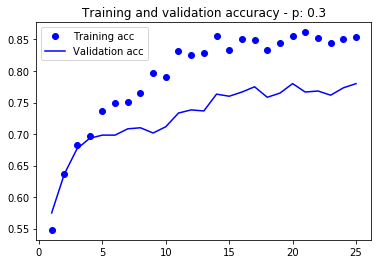

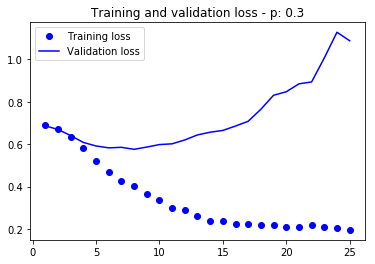

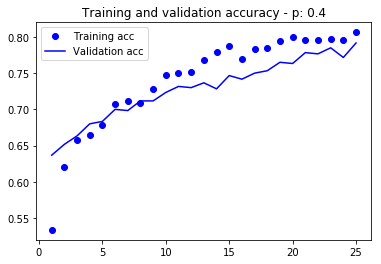

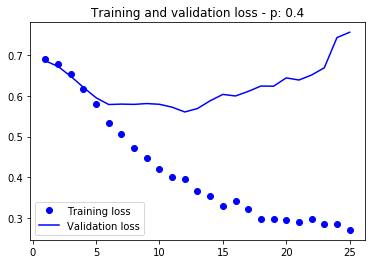

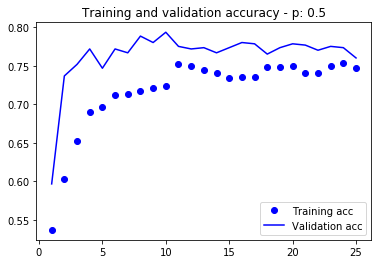

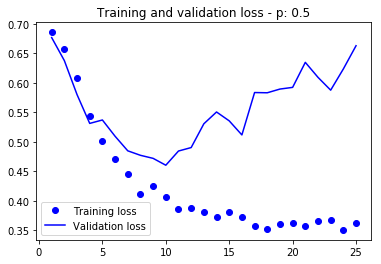

In [43]:
for history, p in zip(arr_hist, dropout_p):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy - p: {}'.format(p))
    plt.legend(loc='best')

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss - p: {}'.format(p))
    plt.legend(loc='best')
    
    plt.show()

In [44]:
from keras.layers import Bidirectional

def create_model_bidirectional(dropout_=False, p=0.0):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Bidirectional(LSTM(units=1)))
    
    if dropout_:
        model.add(Dropout(p))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

## Report (item 3)

## Freeze and GloVe

In [ ]:
arr_hist = []

for p in dropout_p:
    model = create_model_bidirectional(dropout_=True, p=p)
    
    model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])
    history = model.fit(x_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_val, y_val))
    
    arr_hist.append(history)

Train on 2000 samples, validate on 600 samples
Epoch 1/25
2000/2000 [==============================] - 51s 25ms/step - loss: 0.6912 - acc: 0.5220 - val_loss: 0.6814 - val_acc: 0.6683
Epoch 2/25
1952/2000 [============================>.] - ETA: 1s - loss: 0.6677 - acc: 0.6537